# Evalutation statistique : régression logistique
## Library

In [ ]:
import numpy as np
import pandas as pd
from sas7bdat import SAS7BDAT

import matplotlib.pyplot as plt
import seaborn as sns

import math
import scipy.stats as stats
from scipy.stats import chi2
from scipy.stats import pearsonr, ttest_ind
import statsmodels.api as sm

## DataFrame

In [182]:
file_path = 'individus_ct2013.sas7bdat'
with SAS7BDAT(file_path) as reader:
    df = reader.to_data_frame()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33673 entries, 0 to 33672
Columns: 541 entries, C1C to revmenscc_drap
dtypes: float64(76), object(465)
memory usage: 139.0+ MB


## Périmètre de l'étude
* On s'intérresse uniquement aux individus vivant en couple dans le même logement. 

In [183]:
df = df.query('COUPLE == "1"')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24024 entries, 2 to 33672
Columns: 541 entries, C1C to revmenscc_drap
dtypes: float64(76), object(465)
memory usage: 99.3+ MB


## Variable dépendante binaire
* Créeation d'une variable binaire pour indiquer si la femme est le principal apporteur de ressources
    - [PRACT = 1] == (Oui, l'enquêté est le principal apporteur)
    - [SEXE = 2] == (Femme)

In [184]:

# Créer la nouvelle colonne 'femme_principal_apporteur' avec des valeurs 1 ou 0
df['FPA'] = df.apply(lambda row: 1 if (row['PRACT'] == '1' and row['SEXE'] == '2') else 0, axis=1)

# Compter le nombre de lignes où 'femme_principal_apporteur' est égal à 1
nb_FPA = df['FPA'].sum()

print("Nombre de lignes où 'femme_principal_apporteur' est égal à", nb_FPA)

Nombre de lignes où 'femme_principal_apporteur' est égal à 5080


## Sélection des variables

In [185]:
variables_dict = {
    'etat_civil_familial': ['ANAIS', 'ETAMATRI', 'PACS', 'MER1E', 'PER1E'],
    'situation_travail': ['SITUA', 'CJSITUA', 'RABS', 'STATUTEXT', 'METIER',],
    'revenus_conditions_vie': ['REVMENUC', 'AIDFAM'], 
    'caracteristiques_logement_familial': ['TYPOLOG', 'TYPMEN15', 'NPERS', 'NACTIFS']
}

# Accès aux listes individuelles
print("* Etat civil et familial:", variables_dict['etat_civil_familial'])
print("* Situation travail:", variables_dict['situation_travail'])
print("* Revenus et conditions de vie:", variables_dict['revenus_conditions_vie'])
print("* Caractéristiques du logement et familial:", variables_dict['caracteristiques_logement_familial'])

* Etat civil et familial: ['ANAIS', 'ETAMATRI', 'PACS', 'MER1E', 'PER1E']
* Situation travail: ['SITUA', 'CJSITUA', 'RABS', 'STATUTEXT', 'METIER']
* Revenus et conditions de vie: ['REVMENUC', 'AIDFAM']
* Caractéristiques du logement et familial: ['TYPOLOG', 'TYPMEN15', 'NPERS', 'NACTIFS']


### Identification des types de variables

In [186]:
explicatives = [var for sublist in variables_dict.values() for var in sublist]

numericals = [var for var in explicatives if pd.api.types.is_numeric_dtype(df[var]) or pd.api.types.is_datetime64_any_dtype(df[var])]
categoricals = [var for var in explicatives if isinstance(df[var].dtype, pd.CategoricalDtype) or df[var].dtype == 'object']
target = ['FPA']

print(f"numericals: {numericals}")
print(f"categoricals: {categoricals}")

columns_to_keep = numericals + categoricals + target
df = df[columns_to_keep]

numericals: ['ANAIS', 'REVMENUC', 'NPERS', 'NACTIFS']
categoricals: ['ETAMATRI', 'PACS', 'MER1E', 'PER1E', 'SITUA', 'CJSITUA', 'RABS', 'STATUTEXT', 'METIER', 'AIDFAM', 'TYPOLOG', 'TYPMEN15']


### Nettoyage

In [187]:
df.replace('', 0, inplace=True)
df.replace(' ', 0, inplace=True)
df.fillna(0, inplace=True)

nan_count = df.isna().sum()
zero_count = (df == 0).sum()

print("Nombre de NaN par colonne :")
print(nan_count)

print("\nNombre de 0 par colonne :")
print(zero_count)

df.head(20)

Nombre de NaN par colonne :
ANAIS        0
REVMENUC     0
NPERS        0
NACTIFS      0
ETAMATRI     0
PACS         0
MER1E        0
PER1E        0
SITUA        0
CJSITUA      0
RABS         0
STATUTEXT    0
METIER       0
AIDFAM       0
TYPOLOG      0
TYPMEN15     0
FPA          0
dtype: int64

Nombre de 0 par colonne :
ANAIS            0
REVMENUC      1035
NPERS          112
NACTIFS         78
ETAMATRI         0
PACS         17004
MER1E           18
PER1E           38
SITUA            4
CJSITUA          4
RABS         21471
STATUTEXT    19078
METIER           0
AIDFAM       23932
TYPOLOG          0
TYPMEN15         0
FPA          18944
dtype: int64


,ANAIS,REVMENUC,NPERS,NACTIFS,ETAMATRI,PACS,MER1E,PER1E,SITUA,CJSITUA,RABS,STATUTEXT,METIER,AIDFAM,TYPOLOG,TYPMEN15,FPA
2,1963.0,766.666667,5.0,2.0,2,0,3,2,4,1,0,0,2,1,1,42,0
3,1969.0,0.000000,2.0,1.0,2,0,2,3,1,6,0,0,2,0,1,31,0
5,1971.0,785.714286,4.0,2.0,2,0,2,3,1,4,0,0,1,0,1,42,0
6,1948.0,1466.666667,2.0,2.0,2,0,3,3,1,1,0,0,2,0,1,32,0
7,1961.0,292.608696,4.0,1.0,1,2,2,2,1,6,0,0,2,0,1,41,0
9,1976.0,625.000000,5.0,2.0,2,0,2,2,1,4,11,0,2,0,1,42,0
11,1959.0,450.000000,3.0,3.0,2,0,2,2,1,1,0,0,2,0,1,42,1
15,1966.0,1029.411765,7.0,1.0,2,0,2,2,1,6,0,0,1,0,1,41,0
18,1958.0,2666.666667,2.0,2.0,1,1,2,2,1,1,0,0,9,0,1,32,0
19,1963.0,1300.000000,3.0,2.0,2,0,2,1,1,1,0,0,2,0,1,52,0


In [188]:
print(df.columns)

Index(['ANAIS', 'REVMENUC', 'NPERS', 'NACTIFS', 'ETAMATRI', 'PACS', 'MER1E',
       'PER1E', 'SITUA', 'CJSITUA', 'RABS', 'STATUTEXT', 'METIER', 'AIDFAM',
       'TYPOLOG', 'TYPMEN15', 'FPA'],
      dtype='object')


## Exploration des données
###  1. Compréhension des données
- Utilisez des histogrammes, des diagrammes en barres, des boxplots, etc. pour comprendre la distribution des variables.
- Examinez les distributions de la variable dépendante (binaire) et des variables indépendantes (explicatives).


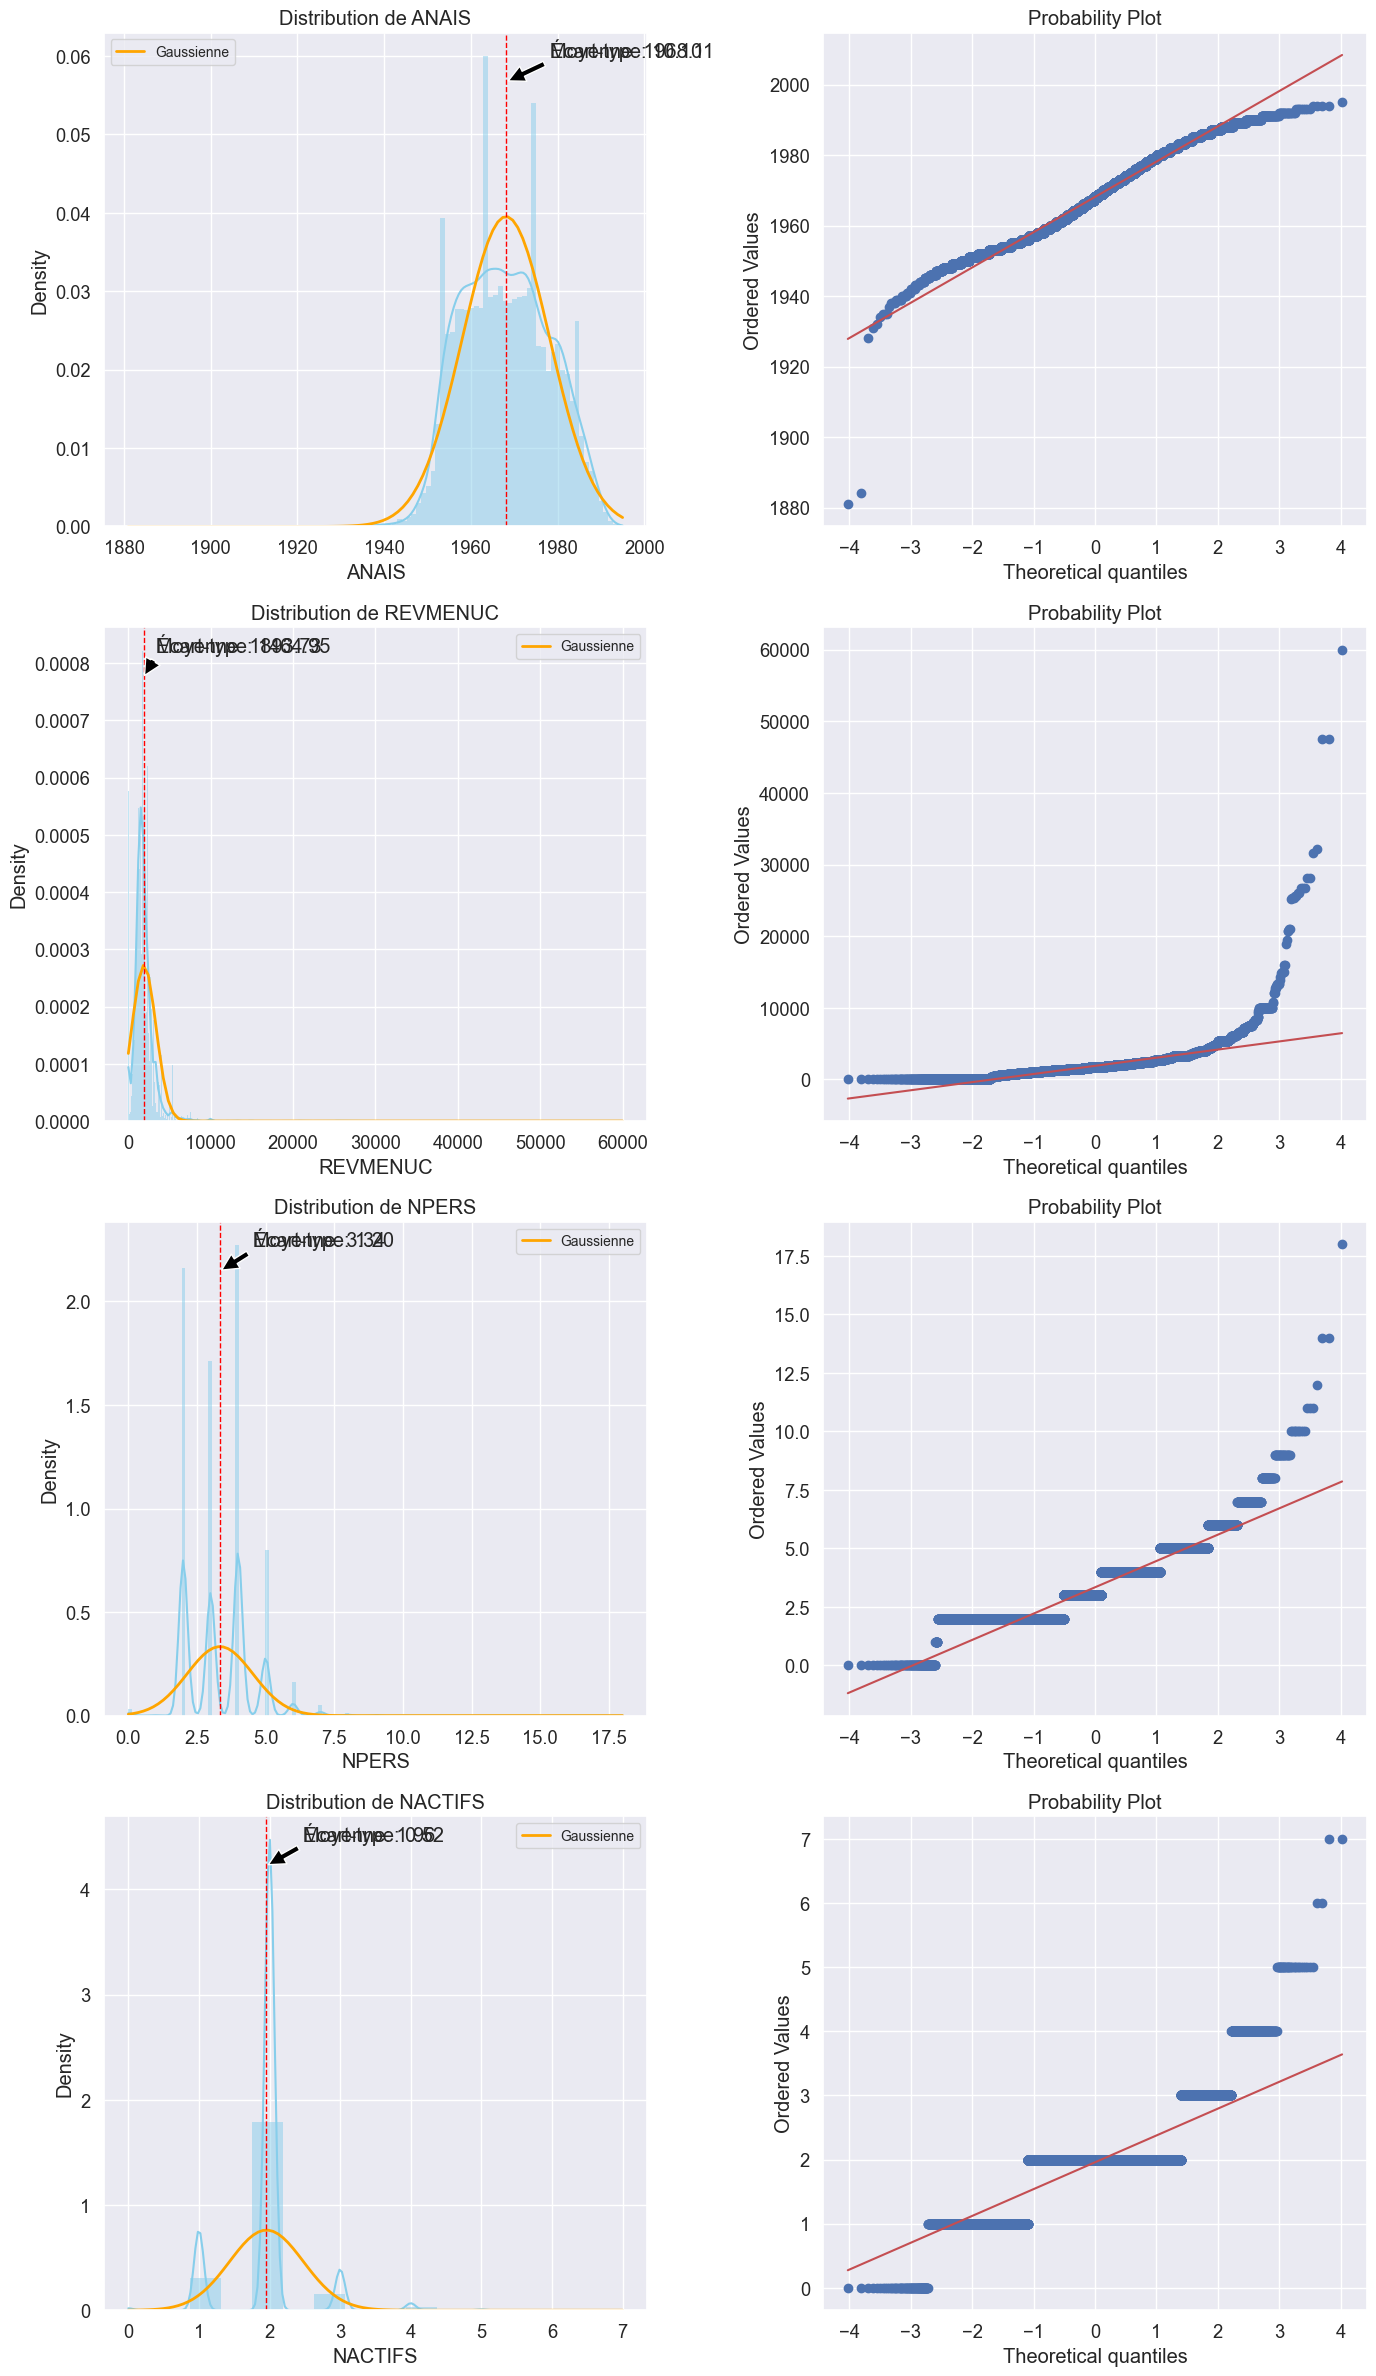

In [189]:
def plot_continuous_variables(df, numericals):
    # Créer une grille de sous-plots avec 2 colonnes
    num_vars = len(numericals)
    fig, axes = plt.subplots(num_vars, 2, figsize=(14, 6*num_vars))
    
    for i, var in enumerate(numericals):
        # Distribution de la variable (courbe de Gauss)
        ax = axes[i, 0]
        ax.set_title(f'Distribution de {var}')
        ax.grid(True)
        
        # Utiliser seaborn pour un tracé rapide de la distribution (peut utiliser d'autres bibliothèques selon votre choix)
        sns.histplot(df[var], kde=True, ax=ax, color='skyblue', stat='density', linewidth=0)
        
        # Tracer la courbe de Gauss correspondante
        xmin, xmax = df[var].min(), df[var].max()
        mean, std_dev = df[var].mean(), df[var].std()
        x = np.linspace(xmin, xmax, 100)
        ax.plot(x, stats.norm.pdf(x, mean, std_dev), label='Gaussienne', color='orange', linewidth=2)
        ax.legend(prop={'size': 10})
        
        # Ajouter des annotations pour la moyenne et l'écart-type
        ax.axvline(mean, color='red', linestyle='dashed', linewidth=1)
        ax.annotate(f'Moyenne: {mean:.2f}', xy=(mean, ax.get_ylim()[1]*0.9), xytext=(mean + std_dev, ax.get_ylim()[1]*0.95),
                    arrowprops=dict(facecolor='black', shrink=0.05))
        ax.annotate(f'Écart-type: {std_dev:.2f}', xy=(mean + std_dev, ax.get_ylim()[1]*0.95))
        
        # Q-Q plot de la variable
        ax = axes[i, 1]
        ax.set_title(f'Q-Q plot de {var}')
        ax.grid(True)
        
        # Utiliser scipy.stats pour calculer le Q-Q plot
        stats.probplot(df[var], dist="norm", plot=ax)
        
    # Ajuster l'espacement entre les sous-graphiques
    plt.tight_layout()
    plt.show()

plot_continuous_variables(df, numericals)

### 2. Analyse préliminaire
#### Variables continues : 
    - Analyse de corrélation
    - Test de Student

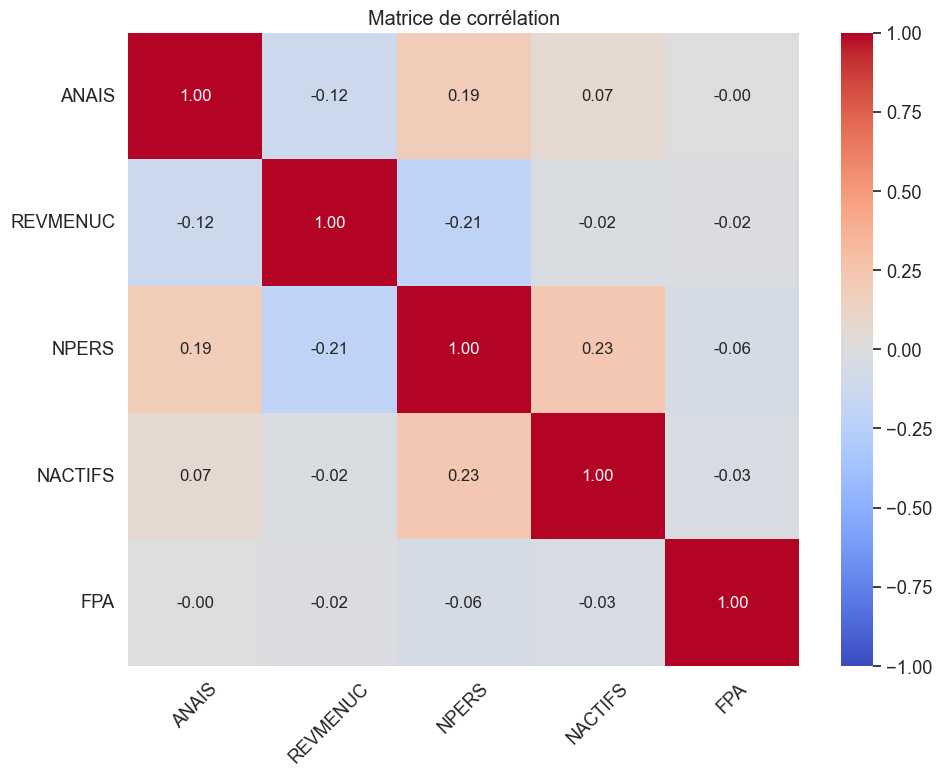

In [190]:
def plot_correlation_matrix(df, numericals, target):

    corr_matrix = df[numericals + target].corr()
    plt.figure(figsize=(10, 8))
    sns.set(font_scale=1.2)
    
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 12}, vmin=-1, vmax=1)
    
    # Ajouter le titre et ajuster les marges
    plt.title('Matrice de corrélation')
    plt.yticks(rotation=0)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Afficher le plot
    plt.show()

plot_correlation_matrix(df, numericals, target)

####  Test de Student Formulation de l'hypothèse nulle et alternative :

Hypothèse nulle (H0) : Il n'y a pas de différence significative entre les moyennes des variables continues pour les groupes définis par la variable 'FPA'.
Hypothèse alternative (H1) : Il y a une différence significative entre les moyennes des variables continues pour les groupes définis par la variable 'FPA'.

In [191]:
def test_association_with_fpa(df, numericals, target, alpha=0.05):
    print("___Test de Student___\n")
    results = {}
    
    for var in numericals:
        
        group1 = df[df[target] == 0][var]           # Séparer les données en deux groupes selon la variable cible 'FPA'
        group2 = df[df[target] == 1][var]
        
        t_stat, p_value = stats.ttest_ind(group1, group2)
        results[var] = (t_stat, p_value)
        
        
        print(f"Variable : {var}, Statistique t : {t_stat:.4f}, Valeur p : {p_value:.4f}")
        
        # Interpréter les résultats
        if p_value < alpha:
            print(f"--> Il y a une association significative entre '{var}' et '{target}'\n")
        else:
            print(f"--> Pas assez de preuves pour conclure une association significative entre '{var}' et '{target}'\n")

test_association_with_fpa(df, numericals, target, alpha=0.05)

___Test de Student___

Variable : ANAIS, Statistique t : nan, Valeur p : nan
--> Pas assez de preuves pour conclure une association significative entre 'ANAIS' et '['FPA']'

Variable : REVMENUC, Statistique t : nan, Valeur p : nan
--> Pas assez de preuves pour conclure une association significative entre 'REVMENUC' et '['FPA']'

Variable : NPERS, Statistique t : nan, Valeur p : nan
--> Pas assez de preuves pour conclure une association significative entre 'NPERS' et '['FPA']'

Variable : NACTIFS, Statistique t : nan, Valeur p : nan
--> Pas assez de preuves pour conclure une association significative entre 'NACTIFS' et '['FPA']'



#### Variables catégorielles : 
- Utilisez des tableaux de contingence pour les variables catégorielles.  
- Utilisez le test du χ² pour les variables catégorielles pour évaluer leur association avec la variable dépendante.      

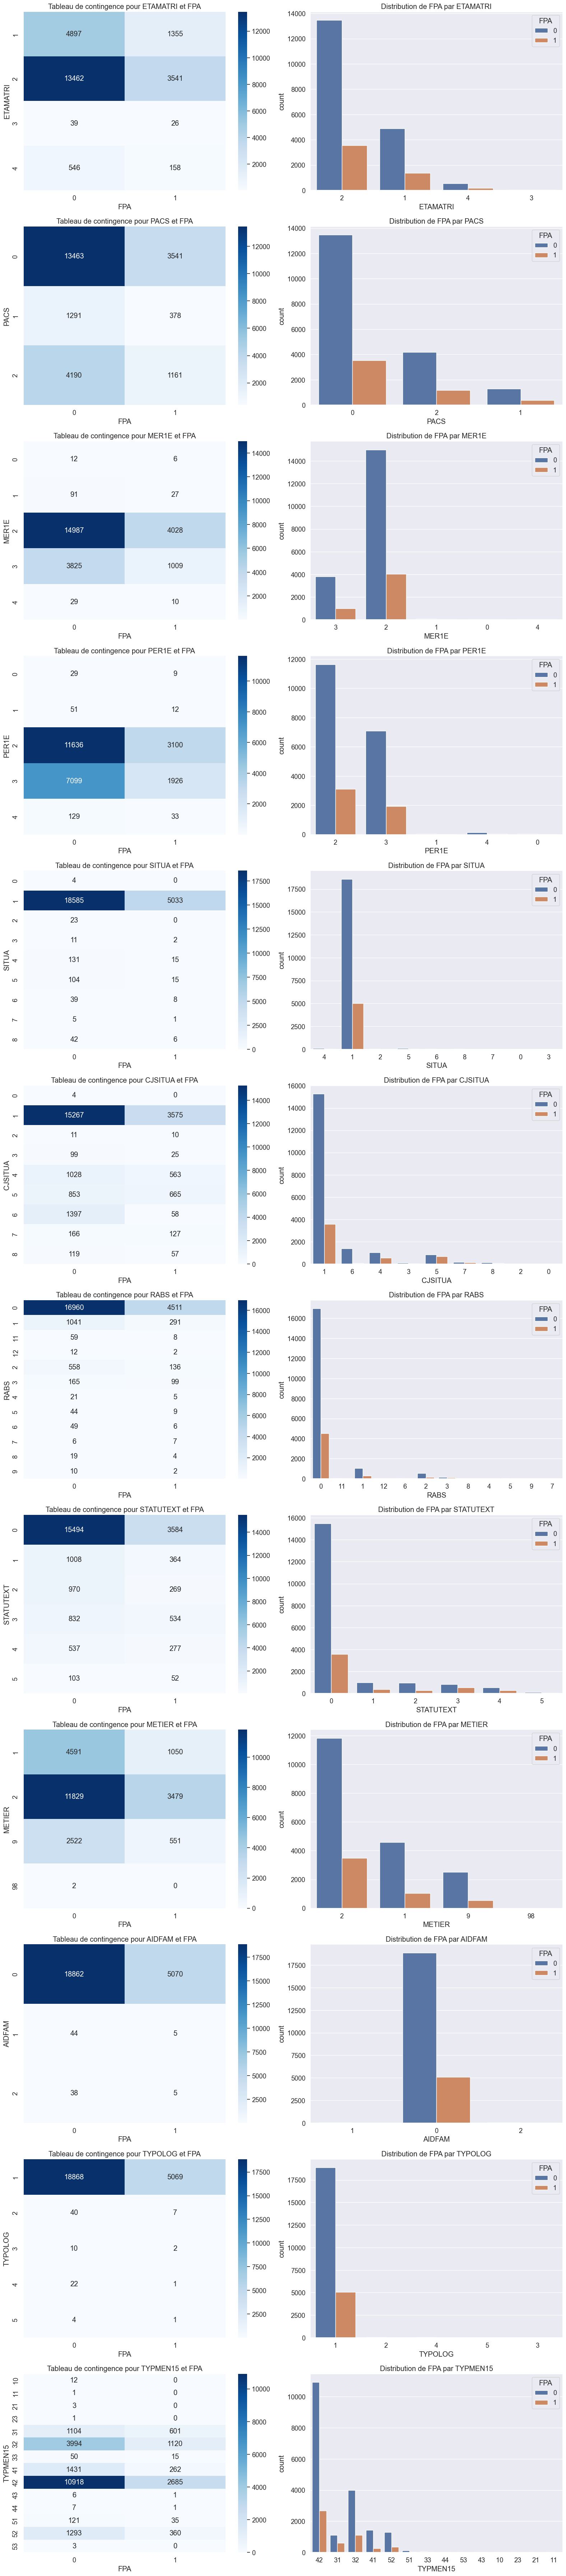

In [192]:
def create_contingency_tables(df, categoricals, target='FPA'):

    num_categoricals = len(categoricals)
    fig, axs = plt.subplots(num_categoricals, 2, figsize=(16, num_categoricals * 6))
    
    for i, var in enumerate(categoricals):
        # Créer un tableau de contingence entre la variable catégorielle et 'FPA'
        contingency_table = pd.crosstab(df[var], df[target])
        
        # Afficher le tableau de contingence à gauche
        axs[i, 0].set_title(f'Tableau de contingence pour {var} et {target}')
        sns.heatmap(contingency_table, annot=True, fmt='d', cmap='Blues', ax=axs[i, 0])
        
        # Créer un graphique à droite montrant la distribution de 'FPA' par catégorie de la variable catégorielle
        sns.countplot(x=var, hue=target, data=df, ax=axs[i, 1])
        axs[i, 1].set_title(f'Distribution de {target} par {var}')
        axs[i, 1].legend(title=target)
        
        # Ajuster l'espacement entre les subplots
        plt.tight_layout()
    
    # Afficher les graphiques
    plt.show()

create_contingency_tables(df, categoricals, target='FPA')

#### Test du Khi-Deux (Formulation de l'hypothèse nulle et alternative) :
- Hypothèse nulle (H0) : Il n'y a pas de relation entre la variable catégorielle et la variable cible 'FAP'.
- Hypothèse alternative (H1) : Il y a une relation entre la variable catégorielle et la variable cible 'FAP'.

In [193]:
def khi2_test_association(df, categoricals, target='FAP', alpha=0.05):
   
    results = []
    
    for var in categoricals:
        # Créer un tableau de contingence entre la variable catégorielle et 'FAP'
        contingency_table = pd.crosstab(df[var], df[target])
        
        # Effectuer le test du chi-deux
        chi2, p_value, _, _ = stats.chi2_contingency(contingency_table)
        
        # Interpréter les résultats
        if p_value < alpha:
            impact = 'Yes'
        else:
            impact = 'No'
        
        # Ajouter les résultats à la liste
        results.append({
            'variable': var,
            'statistique': chi2,
            'p-value': p_value,
            'impact': impact
        })
        
        # Afficher les résultats
        print(f"Variable : {var}, Statistique Khi2 : {chi2:.4f}, Valeur p : {p_value:.4f}, Impact : {impact}")
    
    # Créer un DataFrame à partir des résultats
    df_results = pd.DataFrame(results)
    
    # Appliquer le style conditionnel pour mettre en évidence les lignes avec impact == 'Yes'
    df_styled = df_results.style.apply(lambda row: ['background-color: lightgreen' if x == 'Yes' else '' for x in row], axis=1)
    
    return df_styled

khi2_test_association(df, categoricals, target='FPA', alpha=0.05)

Variable : ETAMATRI, Statistique Khi2 : 16.6552, Valeur p : 0.0008, Impact : Yes
Variable : PACS, Statistique Khi2 : 4.2869, Valeur p : 0.1173, Impact : No
Variable : MER1E, Statistique Khi2 : 2.5211, Valeur p : 0.6409, Impact : No
Variable : PER1E, Statistique Khi2 : 0.6820, Valeur p : 0.9535, Impact : No
Variable : SITUA, Statistique Khi2 : 26.1400, Valeur p : 0.0010, Impact : Yes
Variable : CJSITUA, Statistique Khi2 : 1081.2039, Valeur p : 0.0000, Impact : Yes
Variable : RABS, Statistique Khi2 : 60.5174, Valeur p : 0.0000, Impact : Yes
Variable : STATUTEXT, Statistique Khi2 : 446.9940, Valeur p : 0.0000, Impact : Yes
Variable : METIER, Statistique Khi2 : 64.2253, Valeur p : 0.0000, Impact : Yes
Variable : AIDFAM, Statistique Khi2 : 5.8765, Valeur p : 0.0530, Impact : No
Variable : TYPOLOG, Statistique Khi2 : 5.1558, Valeur p : 0.2717, Impact : No
Variable : TYPMEN15, Statistique Khi2 : 260.5636, Valeur p : 0.0000, Impact : Yes


,variable,statistique,p-value,impact
0,ETAMATRI,16.655159,0.000832,Yes
1,PACS,4.286882,0.117251,No
2,MER1E,2.521053,0.640870,No
3,PER1E,0.682018,0.953528,No
4,SITUA,26.140004,0.000994,Yes
5,CJSITUA,1081.203884,0.000000,Yes
6,RABS,60.517425,0.000000,Yes
7,STATUTEXT,446.994010,0.000000,Yes
8,METIER,64.225270,0.000000,Yes
9,AIDFAM,5.876471,0.052959,No


### 3. Multicolinéarité
* Éviter la multicolinéarité
    - Calculez le Variance Inflation Factor (VIF) pour chaque variable explicative afin de détecter la multicolinéarité.
    - Supprimez ou combinez les variables fortement corrélées pour réduire la multicolinéarité.

In [194]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # Convertit en numérique, remplace les erreurs par NaN

X = sm.add_constant(df)  # Ajoute la constante pour estimer l'intercept
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Affichage des résultats
print("Variance Inflation Factors (VIF):")
print(vif_data)

Variance Inflation Factors (VIF):
      Feature           VIF
0       const  66104.784858
1       ANAIS      1.682001
2    REVMENUC      1.090635
3       NPERS      1.693385
4     NACTIFS      1.683024
5    ETAMATRI      1.401794
6        PACS      1.403065
7       MER1E      1.225671
8       PER1E      1.324604
9       SITUA      1.330397
10    CJSITUA      1.640821
11       RABS      1.020962
12  STATUTEXT      1.031086
13     METIER      1.007160
14     AIDFAM      1.257930
15    TYPOLOG      1.001360
16   TYPMEN15      1.657077
17        FPA      1.029769


### 4. Analyse de variance
* Analyse de variance
    - Effectuez des ANOVA pour tester les différences de moyennes entre les groupes définis par chaque catégorie par rapport à la variable dépendante.

    Formulation des hypothèses :

        - H0 (hypothèse nulle) : Les moyennes des groupes définis par la variable catégorielle sont égales.
        - H1 (hypothèse alternative) : Au moins une paire de moyennes des groupes est différente.

In [195]:
def anova_test(df, categoricals, target='FPA', alpha=0.05):
    
    results = []
    
    for var in categoricals:
        # Collecter les données pour l'ANOVA
        groups = []
        for category in df[var].unique():
            group_data = df[df[var] == category][target]
            groups.append(group_data)
        
        # Effectuer l'ANOVA
        f_statistic, p_value = stats.f_oneway(*groups)
        
        # Interpréter les résultats
        if p_value < alpha:
            result = 'Yes'
        else:
            result = 'No'
        
        # Ajouter les résultats à la liste
        results.append({
            'variable': var,
            'statistique F': f_statistic,
            'p-value': p_value,
            'result': result
        })
            
    # Créer un DataFrame à partir des résultats avec 'Yes' ou 'No'
    df_results = pd.DataFrame(results)
    
    # Appliquer le style conditionnel pour mettre en évidence les lignes avec result == 'Yes'
    def highlight_yes(s):
        return ['background-color: lightgreen' if v == 'Yes' else '' for v in s]
    
    styled_df = df_results.style.apply(highlight_yes, subset=['result'])

    return styled_df 

styled_results = anova_test(df, categoricals, target='FPA', alpha=0.05)
styled_results 

,variable,statistique F,p-value,result
0,ETAMATRI,5.554646,0.000831,Yes
1,PACS,2.143556,0.117260,No
2,MER1E,0.630198,0.640921,No
3,PER1E,0.170474,0.953540,No
4,SITUA,3.269834,0.000991,Yes
5,CJSITUA,141.466580,0.000000,Yes
6,RABS,5.512723,0.000000,Yes
7,STATUTEXT,91.070954,0.000000,Yes
8,METIER,21.462235,0.000000,Yes
9,AIDFAM,2.938587,0.052959,No


### 5. Construction du modèle
* Construction initiale
    - Construisez le modèle de régression logistique en incluant les variables indépendantes sélectionnées.

In [196]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

df[categoricals] = df[categoricals].astype(str)

# Séparer les features et la target
X = df[numericals + categoricals]  # Les variables explicatives
y = df['FPA']                            # La variable cible

# Préparer les transformations pour les données
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Imputer les valeurs manquantes avec la moyenne
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputer les valeurs manquantes avec la valeur la plus fréquente
    ('onehot', OneHotEncoder(drop='first'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numericals),
        ('cat', categorical_transformer, categoricals)
    ])

# Créer un pipeline avec le préprocesseur et le modèle
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000))
    ])

# Séparer les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraîner le modèle
model.fit(X_train, y_train)

# Faire des prédictions et évaluer le modèle
y_pred = model.predict(X_test)

# Rapport de classification
print(classification_report(y_test, y_pred))

# Matrice de confusion
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.84      0.71      0.77      3756
           1       0.33      0.51      0.40      1049

    accuracy                           0.66      4805
   macro avg       0.58      0.61      0.58      4805
weighted avg       0.73      0.66      0.69      4805

[[2657 1099]
 [ 515  534]]


* Précision (Precision) : C'est la proportion d'observations positives prédites correctement parmi toutes les observations prédites comme positives. Pour la classe 0 (première ligne), la précision est de 84%, ce qui signifie que parmi toutes les prédictions positives pour la classe 0, 84% étaient effectivement correctes. Pour la classe 1, la précision est de 33%, ce qui indique que seulement 33% des prédictions positives pour la classe 1 étaient correctes.

* Rappel (Recall) : C'est la proportion d'observations positives réelles prédites correctement parmi toutes les observations positives réelles. Pour la classe 0, le rappel est de 71%, ce qui signifie que le modèle a identifié 71% de toutes les instances de la classe 0. Pour la classe 1, le rappel est de 51%, ce qui indique que le modèle a identifié 51% de toutes les instances de la classe 1.

* F1-score : C'est une mesure de la précision pondérée par le rappel. C'est la moyenne harmonique de la précision et du rappel. Un F1-score élevé indique à la fois une bonne précision et un bon rappel. Pour la classe 0, le F1-score est de 0.77, et pour la classe 1, il est de 0.40.

* Support : C'est le nombre réel d'occurrences de chaque classe dans l'échantillon de test.

* Accuracy (Exactitude) : C'est la proportion totale de prédictions correctes parmi toutes les prédictions. Dans ce cas, l'accuracy est de 66%, ce qui indique que 66% des prédictions globales du modèle sont correctes.

* Macro avg : C'est la moyenne non pondérée des métriques de chaque classe. Pour la précision, le rappel et le F1-score, il s'agit de la moyenne des valeurs des deux classes.

* Weighted avg : C'est la moyenne pondérée des métriques de chaque classe, selon le nombre d'échantillons de chaque classe. Cela donne une meilleure idée des performances globales du modèle compte tenu de la distribution des classes dans l'ensemble de données.

* Matrice de confusion : Cette matrice montre la performance du modèle en termes de vrais positifs (en haut à gauche), faux positifs (en haut à droite), faux négatifs (en bas à gauche) et vrais négatifs (en bas à droite). Elle donne une vue détaillée des erreurs de classification du modèle.

### 6. Diagnostic du modèle
* Vérification de la linéarité en logit

    - Utilisez des graphiques de régression partielle pour vérifier que la relation entre chaque variable indépendante et le logit de la variable dépendante est linéaire.

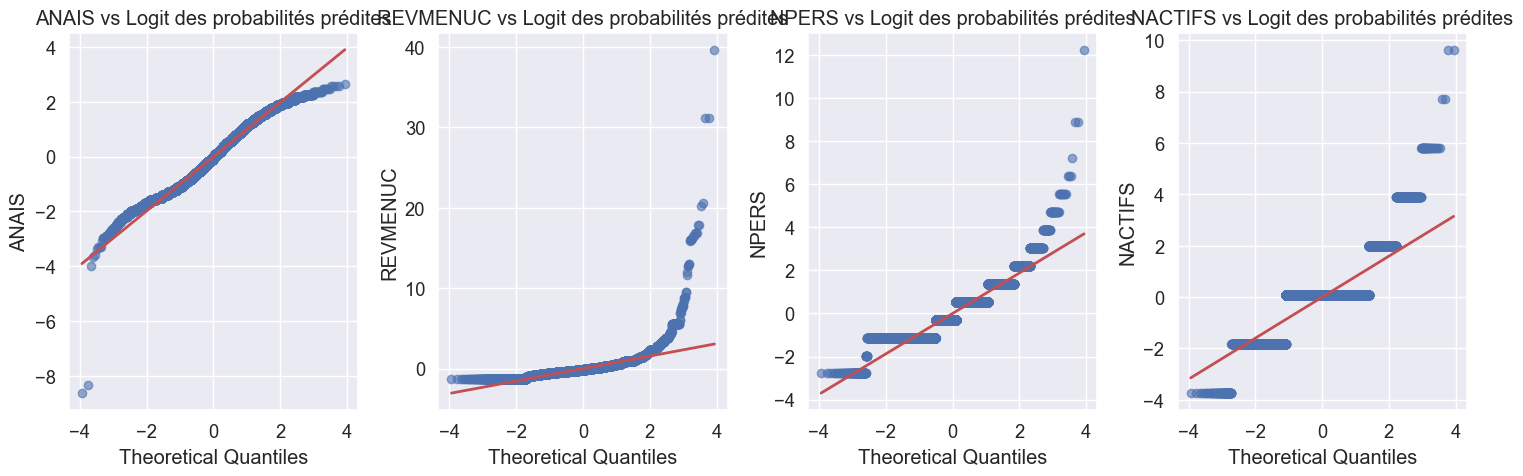

In [197]:
from statsmodels.graphics.gofplots import ProbPlot

def check_linearity_in_logit(df, numericals, target='FPA'):

    # Ajouter une constante au DataFrame
    df = sm.add_constant(df)
    
    # Ajuster le modèle de régression logistique
    logit_model = sm.Logit(df[target], df[numericals])
    logit_results = logit_model.fit(disp=0)
    
    # Calculer les probabilités prédites en logit
    predicted_logit = logit_results.predict()
    
    # Tracer les graphiques de dispersion
    fig, axes = plt.subplots(nrows=1, ncols=len(numericals), figsize=(15, 5))
    
    for i, var in enumerate(numericals):
        # Tracer le graphique de dispersion (variable continue vs logit des probabilités prédites)
        probplot = ProbPlot(df[var], fit=True)
        axes[i].scatter(probplot.theoretical_quantiles, probplot.sample_quantiles, alpha=0.6)
        axes[i].set_title(f"{var} vs Logit des probabilités prédites")
        axes[i].set_xlabel(f"Theoretical Quantiles")
        axes[i].set_ylabel(f"{var}")
        axes[i].grid(True)
        
        # Ajouter la droite de régression linéaire
        fit = np.polyfit(probplot.theoretical_quantiles, probplot.sample_quantiles, 1)
        axes[i].plot(probplot.theoretical_quantiles, np.polyval(fit, probplot.theoretical_quantiles), 'r-', linewidth=2)
    
    plt.tight_layout()
    plt.show()

# Appeler la fonction pour vérifier la linéarité en logit pour les variables continues
check_linearity_in_logit(df, numericals, target='FPA')

* Indépendance des observations Utilisez des tests comme le test de Durbin-Watson pour détecter l'autocorrélation dans les résidus.

In [198]:
from statsmodels.stats.stattools import durbin_watson
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import chi2

categoricals = ['ETAMATRI', 'SITUA', 'CJSITUA', 'RABS', 'STATUTEXT', 'METIER', 'TYPMEN15']
numericals = ['ANAIS', 'REVMENUC', 'NPERS', 'NACTIFS']


def final_model(df, numericals, categoricals, target='FPA', num_groups=10):
    # Ajouter une constante au DataFrame
    df = sm.add_constant(df)
    
    # Sélectionner les variables explicatives pour le modèle de régression logistique
    exog_numericals = df[numericals].values
    exog_categoricals = pd.get_dummies(df[categoricals], drop_first=True).values
    
    # Combiner les variables explicatives
    exog = np.concatenate((exog_numericals, exog_categoricals), axis=1)
    
    # Ajuster le modèle de régression logistique
    model = sm.Logit(df[target], exog)
    results = model.fit()

    # Calculer les résidus deviance standardisés
    residuals = results.resid_pearson

    # TEST DE DURBIN-WATSON

    # Effectuer le test de Durbin-Watson
    durbin_watson_statistic = durbin_watson(residuals)
    print(f"\n----------------------------------\nStatistique de Durbin-Watson : {durbin_watson_statistic:.4f}")

    # Interpréter les résultats du test de Durbin-Watson
    if durbin_watson_statistic < 1.5:
        print("Les résidus montrent une autocorrélation positive.")
    elif durbin_watson_statistic > 2.5:
        print("Les résidus montrent une autocorrélation négative.")
    else:
        print("Les résidus ne montrent pas d'autocorrélation significative.")

    # TEST DE HOSMER-LEMESHOW

    y_true = df[target].values  # Utiliser le nom de la variable cible dans votre DataFrame
    y_prob = results.predict(exog)  # Utiliser le modèle pour prédire les probabilités avec les mêmes variables explicatives utilisées pour l'entraînement

    # Vérification des dimensions des données
    if len(y_true) != len(y_prob):
        raise ValueError("Les dimensions de y_true et y_prob doivent être identiques.")
    
    # Créer les groupes en fonction des probabilités prédites
    y_true = np.asarray(y_true)
    y_prob = np.asarray(y_prob)
    deciles = np.percentile(y_prob, np.arange(0, 100, 100/num_groups))
    groups = np.digitize(y_prob, deciles)
    
    # Initialisation des tableaux pour les fréquences observées et attendues
    obs_freq = np.zeros(num_groups)
    exp_freq = np.zeros(num_groups)
    
    # Calcul des fréquences observées et attendues pour chaque groupe
    for i in range(num_groups):
        obs_freq[i] = np.sum((groups == (i + 1)) * y_true)
        exp_freq[i] = np.sum(groups == (i + 1)) * np.mean(y_true)
    
    # Calcul de la statistique de test de Hosmer-Lemeshow
    chi2_statistic = np.sum((obs_freq - exp_freq)**2 / exp_freq)
    
    # Degré de liberté est (num_groups - 2) car il y a num_groups - 1 groupes et 2 paramètres (intercept et pente)
    df = num_groups - 2
    
    # Calcul de la valeur p
    p_value = 1 - chi2.cdf(chi2_statistic, df)

    print(f"\n----------------------------------\nStatistique du test de Hosmer-Lemeshow : {chi2_statistic:.4f}")
    print(f"Valeur p : {p_value:.4f}")

    # Interpréter les résultats du test de Hosmer-Lemeshow
    if p_value < 0.05:
        print("Le modèle ne correspond pas bien aux données observées (rejet de l'hypothèse nulle).\n")
    else:
        print("Le modèle correspond bien aux données observées (absence de preuve pour rejeter l'hypothèse nulle).\n")
    
# Appeler la fonction pour ajuster le modèle final
final_model(df, numericals, categoricals, target='FPA', num_groups=10)


         Current function value: 0.480418
         Iterations: 35

----------------------------------
Statistique de Durbin-Watson : 1.8546
Les résidus ne montrent pas d'autocorrélation significative.

----------------------------------
Statistique du test de Hosmer-Lemeshow : 1291.8214
Valeur p : 0.0000
Le modèle ne correspond pas bien aux données observées (rejet de l'hypothèse nulle).



/Users/mariusayrault/GitHub/Sorb-Data-Analytics/projet-statistique/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


* Adéquation du modèle
    - Utilisez des méthodes de diagnostic comme le test de Hosmer-Lemeshow pour évaluer si le modèle ajusté correspond bien aux données observées.

### 7. Validation du modèle
* Validation croisée
    - Divisez les données en ensembles d'entraînement et de test pour valider le modèle.
    - Utilisez des mesures de performance comme l'accuracy, la précision, le rappel et l'AUC-ROC pour évaluer le modèle.